In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# models
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import itertools
import time
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xg

# warnings
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

import os
from google.colab import drive

In [21]:
drive.mount('/content/drive')

path = '/content/drive/My Drive/DSO 530'

train_df = pd.read_csv(os.path.join(path,'option_train.csv'),index_col = 'Unnamed: 0',usecols=lambda column: column not in ['BS'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
train_df.head()

,Value,S,K,tau,r
1,348.500,1394.46,1050,0.128767,0.0116
2,149.375,1432.25,1400,0.679452,0.0113
3,294.500,1478.90,1225,0.443836,0.0112
4,3.375,1369.89,1500,0.117808,0.0119
5,84.000,1366.42,1350,0.298630,0.0119


## Features in Regression Models

For regression models, we use 3 additional features that have promising relationship with Value (C):

*   S/K (moneyness)
*   |S-K|
* max(S-K,0) (intrinsic value)



In [23]:
train_df['S/K'] = train_df['S']/train_df['K']
train_df['S-K_abs'] = abs(train_df['S']-train_df['K'])
train_df['intrinsic_value'] = train_df.apply(lambda row: max(row['S'] - row['K'], 0), axis=1)

In [24]:
X_train, y_train = train_df.drop(columns=['Value']), train_df['Value']

In [25]:
# Feature scaling
stdsc = StandardScaler()

X_train_std = stdsc.fit_transform(X_train)
X_train_std = pd.DataFrame(X_train_std, columns=X_train.columns)

# Model Building

In [26]:
kfolds = KFold(n_splits = 10, shuffle = True, random_state = 1)

## Linear Regression

In [27]:
# Default Model
lin_reg = LinearRegression()
lin_reg_cv = cross_val_score(lin_reg, X=X_train_std, y=y_train, cv=kfolds)
print('r2 of 10-folds:', lin_reg_cv)
print('mean r2:', np.mean(lin_reg_cv))

r2 of 10-folds: [0.99327323 0.99216484 0.99292697 0.99279817 0.99276686 0.99334966
 0.99090976 0.99294575 0.9935129  0.99036072]
mean r2: 0.992500886187816


### Best Subset Selection

In [28]:
def processSubset(feature_set):
  # Fit model on feature_set and calculate RSS
  X1 = sm.add_constant(X_train[list(feature_set)])
  model = sm.OLS(y_train,X1)
  regr = model.fit()
  RSS = ((regr.predict(X1) - y_train) ** 2).sum()
  return {"model":regr, "RSS":RSS}

In [29]:
def getBest(k):

  tic = time.time()

  results = []

  for combo in itertools.combinations(X_train.columns, k):
    results.append(processSubset(combo))

  # Wrap everything up in a nice dataframe
  models = pd.DataFrame(results)

  # Choose the model with the smallest RSS
  best_model = models.loc[models['RSS'].idxmin()]
  # idxmin() function returns index of first occurrence of minimum.

  toc = time.time()

  print("Processed ", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
  # Return the best model, along with some other useful information about the model
  return best_model

In [30]:
models = pd.DataFrame(columns=["RSS", "model"])

tic = time.time()

for i in range(0,8):
  models.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  1 models on 0 predictors in 0.03113389015197754 seconds.
Processed  7 models on 1 predictors in 0.039134979248046875 seconds.
Processed  21 models on 2 predictors in 0.2472069263458252 seconds.
Processed  35 models on 3 predictors in 0.5698862075805664 seconds.
Processed  35 models on 4 predictors in 0.6494724750518799 seconds.
Processed  21 models on 5 predictors in 0.4033997058868408 seconds.
Processed  7 models on 6 predictors in 0.16097497940063477 seconds.
Processed  1 models on 7 predictors in 0.03417229652404785 seconds.
Total elapsed time: 2.2074804306030273 seconds.


In [31]:
models

,RSS,model
0,78303206.442656,<statsmodels.regression.linear_model.Regressio...
1,5352871.659427,<statsmodels.regression.linear_model.Regressio...
2,2121722.220042,<statsmodels.regression.linear_model.Regressio...
3,633495.351148,<statsmodels.regression.linear_model.Regressio...
4,585745.470025,<statsmodels.regression.linear_model.Regressio...
5,583950.630596,<statsmodels.regression.linear_model.Regressio...
6,582319.617086,<statsmodels.regression.linear_model.Regressio...
7,582319.617086,<statsmodels.regression.linear_model.Regressio...


In [32]:
# Gets the second element from each row ('model') and pulls out its R rsquared␣ ↪attribute
models.apply(lambda row: row[1].rsquared, axis=1)

0    2.220446e-16
1    9.316392e-01
2    9.729038e-01
3    9.919097e-01
4    9.925195e-01
5    9.925424e-01
6    9.925633e-01
7    9.925633e-01
dtype: float64

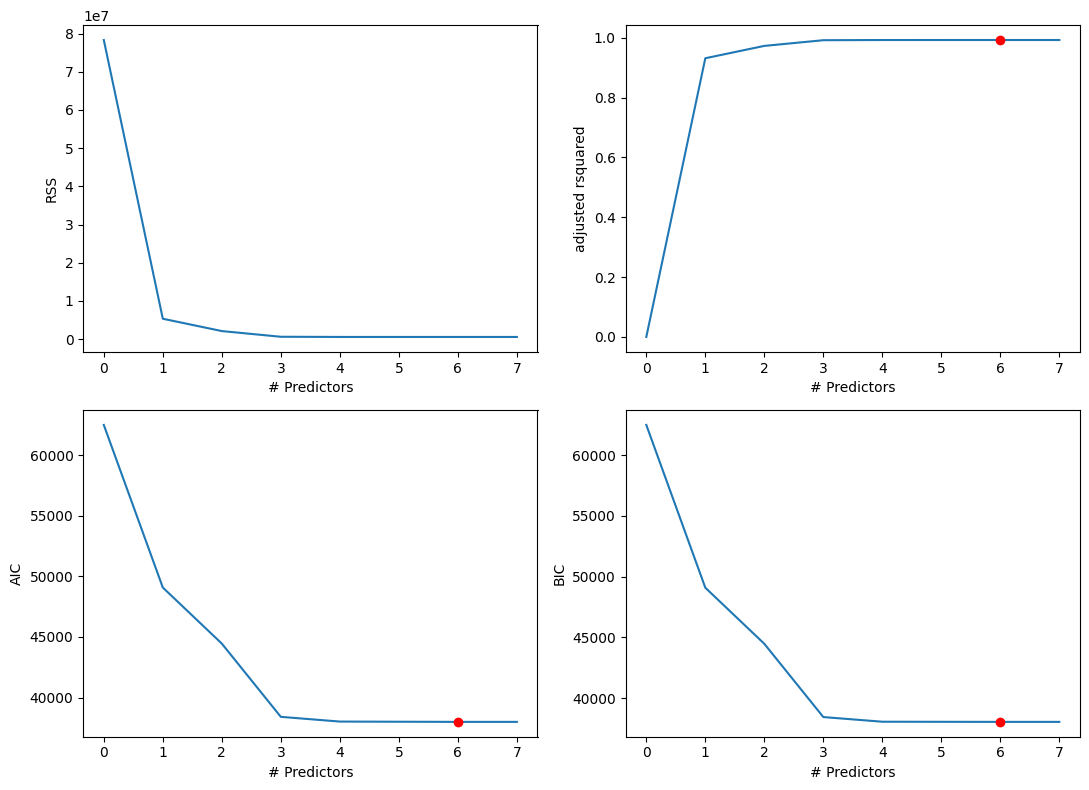

In [33]:
plt.figure(figsize=(11,8))
# plt.rcParams.update({'font.size': 12, 'lines.markersize': 13})

#Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

# We will now plot a curve to show the relationship between the number of predictors and the RSS
plt.plot(models["RSS"])
plt.xlabel('# Predictors')
plt.ylabel('RSS')

# We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
# The idxmax() function can be used to identify the location of the maximum point of a vector
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1)

plt.subplot(2, 2, 2)
plt.plot(rsquared_adj)
plt.plot(rsquared_adj.idxmax(), rsquared_adj.max(), "or")
plt.xlabel('# Predictors')
plt.ylabel('adjusted rsquared')

# We'll do the same for AIC and BIC, this time looking for the models with the␣ ↪SMALLEST statistic
aic = models.apply(lambda row: row[1].aic, axis=1)

plt.subplot(2, 2, 3)
plt.plot(aic)
plt.plot(aic.idxmin(), aic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('AIC')

bic = models.apply(lambda row: row[1].bic, axis=1)

plt.subplot(2, 2, 4)
plt.plot(bic)
plt.plot(bic.idxmin(), bic.min(), "or")
plt.xlabel('# Predictors')
plt.ylabel('BIC')

plt.tight_layout()

We choose to stop at 4 predictors to prioritize model interpretability in linear regression, while not trading off much of adjusted R-squared.

In [34]:
print(models.loc[4, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 1.657e+05
Date:                Wed, 01 May 2024   Prob (F-statistic):               0.00
Time:                        01:54:33   Log-Likelihood:                -19003.
No. Observations:                5000   AIC:                         3.802e+04
Df Residuals:                    4995   BIC:                         3.805e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -130.5409      7.821    -

In [35]:
# Cross validation
lin_reg = LinearRegression()
lin_reg_cv = cross_val_score(lin_reg, X=X_train_std[['tau','S/K','S-K_abs','intrinsic_value']], y=y_train, cv=kfolds)
print('r2 of 10-folds:', lin_reg_cv)
print('mean r2:', np.mean(lin_reg_cv))

r2 of 10-folds: [0.99326282 0.99212658 0.99282108 0.9927643  0.9927807  0.99317912
 0.99089641 0.99294014 0.99350013 0.99037481]
mean r2: 0.9924646086476481


## Decision Tree

In [36]:
# Default Model
tree_reg = DecisionTreeRegressor(random_state=1)
tree_reg_cv = cross_val_score(tree_reg, X=X_train_std, y=y_train, cv=kfolds)
print('r2 of 10-folds:', tree_reg_cv)
print('mean r2:', np.mean(tree_reg_cv))

r2 of 10-folds: [0.99655653 0.99631528 0.99675641 0.99683628 0.99627125 0.99614129
 0.99693207 0.99584495 0.99717119 0.99660568]
mean r2: 0.9965430934568319


## Gradient Boosting

In [37]:
# Default Gradient Boosted Trees Model
boosted_reg = GradientBoostingRegressor(random_state=1) # default max_depth=None, min_samples_split=2
boosted_reg_cv = cross_val_score(boosted_reg, X=X_train_std, y=y_train, cv=kfolds)
print('r2 of 10-folds:', boosted_reg_cv)
print('mean r2:', np.mean(boosted_reg_cv))

r2 of 10-folds: [0.99798555 0.99657526 0.99717534 0.9972029  0.9975702  0.99709225
 0.99753585 0.99715259 0.99766401 0.99772474]
mean r2: 0.9973678676349138


Not tuning much, just increase number of trees to settle the mean CV score.

In [38]:
boosted_reg = GradientBoostingRegressor(random_state=1, n_estimators=300, learning_rate=0.2) # default max_depth=None, min_samples_split=2
boosted_reg_cv = cross_val_score(boosted_reg, X=X_train_std, y=y_train, cv=kfolds)
print('r2 of 10-folds:', boosted_reg_cv)
print('mean r2:', np.mean(boosted_reg_cv))

r2 of 10-folds: [0.99844067 0.99784987 0.99799019 0.99823267 0.99847495 0.99795833
 0.99817236 0.99821102 0.99864205 0.99856616]
mean r2: 0.9982538256932896


## Random Forest

In [39]:
# Default Model
rf_reg = RandomForestRegressor(random_state=1) # default max_feature=100, n_estimator=100
rf_reg_cv = cross_val_score(rf_reg, X=X_train_std, y=y_train, cv=kfolds)
print('r2 of 10-folds:', rf_reg_cv)
print('mean r2:', np.mean(rf_reg_cv))

r2 of 10-folds: [0.99835389 0.99765017 0.99786389 0.99800747 0.99797338 0.99769317
 0.99841689 0.99810638 0.99842279 0.99824059]
mean r2: 0.9980728627117322


### Hyperparameter Tuning

In [41]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2', None] # default = None aka n features
}

In [42]:
rf_reg_grid = GridSearchCV(rf_reg,
                           param_grid=param_grid,
                           cv=kfolds,
                           scoring='r2')
rf_reg_grid.fit(X_train_std, y_train)
print('Best parameter:', rf_reg_grid.best_params_)
print('Mean r2:', rf_reg_grid.best_score_)

Best parameter: {'max_features': None, 'n_estimators': 300}
Mean r2: 0.9980949362262924


In [43]:
best_rf_reg = rf_reg_grid.best_estimator_
best_rf_reg.feature_importances_

array([3.86916805e-04, 1.47530243e-04, 4.46979008e-02, 2.42441768e-04,
       3.57272340e-01, 8.73602458e-02, 5.09892625e-01])

Text(0.5, 0, 'Random Forest Feature Importance')

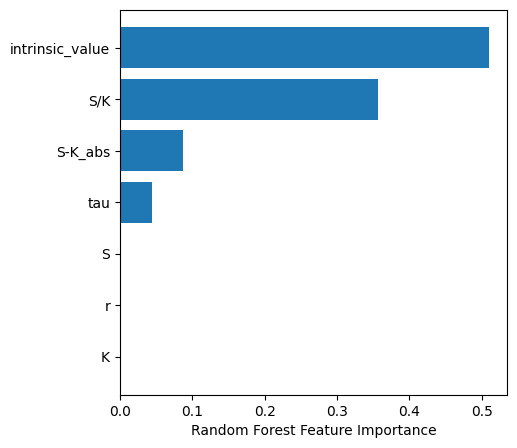

In [44]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5))

sorted_idx = best_rf_reg.feature_importances_.argsort() ## remove [-10:] to get a plot for all features

plt.barh(X_train.columns.values[sorted_idx], best_rf_reg.feature_importances_[sorted_idx])

plt.xlabel("Random Forest Feature Importance")

## XGBoost

In [46]:
# Default Model
xgb_reg = xg.XGBRegressor(seed=1, n_estimators=300, learning_rate=0.2) # default max_feature=100, n_estimator=100
xgb_reg_cv = cross_val_score(xgb_reg, X=X_train_std, y=y_train, cv=kfolds)
print('r2 of 10-folds:', xgb_reg_cv)
print('mean r2:', np.mean(xgb_reg_cv))

r2 of 10-folds: [0.99883839 0.99838186 0.99865353 0.99866998 0.99862986 0.99845126
 0.99892668 0.99871431 0.99899597 0.9990187 ]
mean r2: 0.9987280539047502


### Hyperparameter Tuning

In [47]:
param_grid_xgb = {
    'max_depth': [3, 5, 7],  # Maximum depth of trees
    'learning_rate': [0.01, 0.1, 0.2],  # Learning rate
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree
    'gamma': [0, 0.1, 0.2]  # Minimum loss reduction required to make a further partition
}

In [48]:
xgb_reg_cv = GridSearchCV(xgb_reg, param_grid_xgb, cv=kfolds, scoring='r2', n_jobs=-1)

xgb_reg_cv.fit(X_train_std, y_train)

# Get best hyperparameters and score
print("Best parameters:", xgb_reg_cv.best_params_)
print('Mean r2: ', xgb_reg_cv.best_score_)

Best parameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


Text(0.5, 0, 'XGBoost Regressor Feature Importance')

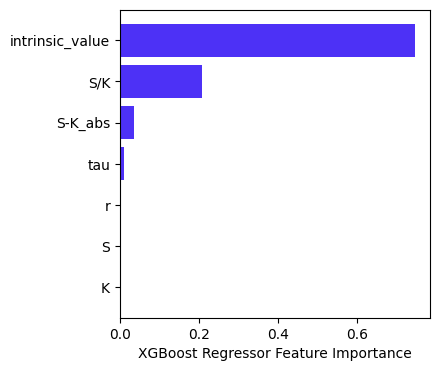

In [50]:
best_xgb_reg = xgb_reg_cv.best_estimator_

fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4))
sorted_idx = best_xgb_reg.feature_importances_.argsort() ## remove [-10:] to get a plot for all features
plt.barh(X_train_std.columns.values[sorted_idx], best_xgb_reg.feature_importances_[sorted_idx],color="#4D31F6")
plt.xlabel("XGBoost Regressor Feature Importance")

# Final Model: XGBoost

In [53]:
test_df = pd.read_csv(os.path.join(path,'option_test_nolabel.csv'), index_col='Unnamed: 0')
test_df

,S,K,tau,r
1,1409.28,1325,0.126027,0.0115
2,1505.97,1100,0.315068,0.0110
3,1409.57,1450,0.197260,0.0116
4,1407.81,1250,0.101370,0.0116
5,1494.50,1300,0.194521,0.0110
...,...,...,...,...
496,1514.09,1200,0.301370,0.0109
497,1359.15,1500,0.260274,0.0119
498,1396.93,1410,0.156164,0.0117
499,1436.51,1475,0.463014,0.0114


In [54]:
test_df['S/K'] = test_df['S']/test_df['K']
test_df['S-K_abs'] = abs(test_df['S']-test_df['K'])
test_df['intrinsic_value'] = test_df.apply(lambda row: max(row['S'] - row['K'], 0), axis=1)

In [55]:
X_test = test_df
X_test

,S,K,tau,r,S/K,S-K_abs,intrinsic_value
1,1409.28,1325,0.126027,0.0115,1.063608,84.28,84.28
2,1505.97,1100,0.315068,0.0110,1.369064,405.97,405.97
3,1409.57,1450,0.197260,0.0116,0.972117,40.43,0.00
4,1407.81,1250,0.101370,0.0116,1.126248,157.81,157.81
5,1494.50,1300,0.194521,0.0110,1.149615,194.50,194.50
...,...,...,...,...,...,...,...
496,1514.09,1200,0.301370,0.0109,1.261742,314.09,314.09
497,1359.15,1500,0.260274,0.0119,0.906100,140.85,0.00
498,1396.93,1410,0.156164,0.0117,0.990730,13.07,0.00
499,1436.51,1475,0.463014,0.0114,0.973905,38.49,0.00


In [56]:
X_test_std = stdsc.transform(X_test)

In [58]:
y_pred = best_xgb_reg.predict(X_test_std)
y_pred

array([ 1.03384270e+02,  4.25714294e+02,  4.94893532e+01,  1.71579712e+02,
        2.12535782e+02,  2.83112091e+02,  4.05848198e+01,  2.50150055e+02,
        2.88773376e+02,  1.00950455e+02,  7.18498993e+01,  1.34077423e+02,
        9.04537487e+00,  8.48894882e+01,  1.88655701e+02,  2.68888149e+01,
        3.07435932e+01,  4.72348518e+01,  3.15006237e+01,  7.44436264e+01,
        1.13773926e+02,  5.54910812e+01,  6.30606766e+01,  5.03908386e+01,
        8.67591629e+01,  2.49673553e+02,  5.36972885e+01,  1.65869934e+02,
        4.07026863e+01,  1.40122742e+02,  1.05156090e+02,  2.68742310e+02,
        6.51739044e+01,  2.42612259e+02,  3.75513031e+02,  5.59000206e+00,
        3.33053131e+02,  1.01669865e+01,  5.38162689e+01,  5.92317467e+01,
        3.22619537e+02,  1.84671555e+02,  2.62884186e+02,  4.32288933e+01,
        7.09300156e+01,  1.07065926e+02,  3.83501892e+01,  3.63110161e+01,
        1.56635406e+02,  5.00795631e+01,  4.06452972e+02,  8.37747650e+01,
        2.87061558e+01,  

In [59]:
y_pred_df = pd.DataFrame(y_pred, columns=['Value'])
y_pred_df

,Value
0,103.384270
1,425.714294
2,49.489353
3,171.579712
4,212.535782
...,...
495,338.787354
496,11.738211
497,46.569248
498,82.212837


array([[<Axes: title={'center': 'Value'}>]], dtype=object)

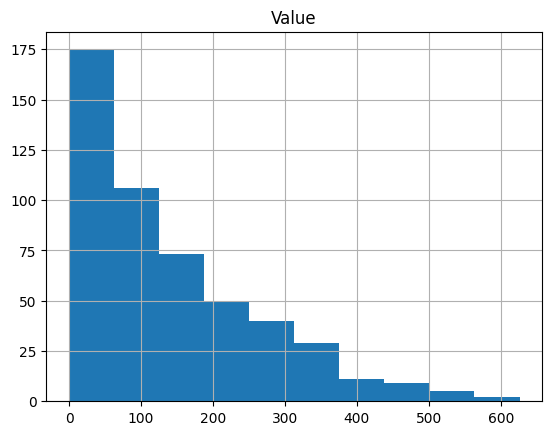

In [60]:
y_pred_df.hist()

In [62]:
# Save DataFrame to CSV file
y_pred_df.to_csv('/content/drive/My Drive/DSO 530/Submission/regression.csv', index=False)